# XGBoost (1) - Basic

XGBoost는 트리 기반의 앙상블 학습에서 가장 각광받고 있는 알고리즘 중 하나.

GBM(GradientBoosstModel)에 기반을 하고 있으면서 GBM의 실행 시간 및 과적합 규제가 없는 부분등의  문제를 해결한 학습모델.

병렬 CPU 환경에서 분산 처리가 가능하기 때문에 기존 모델보다 수행 시간이 단축된다.

`C/C++`로 구현된 독립 라이브러리이기 때문에 sklearn과의 코드 진행이 다소 다르다.

```shell
pip install --upgrade xgboost 설치
```

## #01. 패키지

In [6]:
import warnings
warnings.filterwarnings('ignore')

import numpy as np
import xgboost as xgb
from xgboost import plot_importance

from matplotlib import pyplot as plt
from pandas import read_excel
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
# 성능향상
from imblearn.over_sampling import SMOTE

from sklearn.metrics import confusion_matrix, accuracy_score
from sklearn.metrics import precision_score, recall_score
from sklearn.metrics import f1_score, roc_auc_score

## #02. 데이터 로딩 및 전처리

In [7]:
# 데이터 로드
origin = read_excel("https://data.hossam.kr/G02/breast_cancer.xlsx")
# print(origin.info())
# origin.head()

# 독립/종속변수 분리
x = origin.drop('target', axis=1)
y = origin['target']
# x.shape, y.shape

# 데이터 스케일링
std_x = StandardScaler().fit_transform(x)

# 훈련/검증 데이터 분리(test_size 미지정시 자동 0.25)
x_train, x_test, y_train, y_test = train_test_split(std_x, y, random_state=2021)
x_train.shape, x_test.shape, y_train.shape, y_test.shape

((426, 30), (143, 30), (426,), (143,))

### 데이터 불균형 처리

#### Over Sampling - SMOTE

소수 집단의 데이터를 바탕으로 새로운 데이터를 생성.

단순히 소수 집단의 데이터를 복원 추출하는 것이 아니라 소수 집단 데이터를 분석해 어떤 특징이 있는지 살피고 그와 유사한 패턴을 가지는 가짜 데이터를 생성.

##### `sampling_strategy 파라미터`

sampling_strategy : 2진 분류일 경우 실수로 설정 가능

| 값 | 설명 |
| -- | -- |
| `minority` | `소수 클래스만` 다시 샘플링 |
| `not majority` | `다수 아님` : 다수 클래스를 제외한 모든 클래스를 다시 샘플링 |
| `not minority` | `소수 아님` : 소수 클래스를 제외한 모든 클래스를 다시 샘플링 |
| `all` | `모든 클래스`를 다시 샘플링 |
| `auto` | 자동 처리 |

혹은 실수 타입으로 설정할 경우 샘플 수의 비율을 의미

##### `k_neighbors 파라미터 (int)`

합성 샘플을 생성하는데 사용할 샘플의 가장 가까운 이웃 수 (기본값=5)

In [9]:
# SMOTE 적용
x_sm, y_sm = SMOTE(random_state=2021).fit_resample(x_train, y_train)
x_sm.shape, x_test.shape, y_sm.shape, y_test.shape

((530, 30), (143, 30), (530,), (143,))

## #03. 훈련모델 구축

### XGBoost 전용 데이터 생성

사이킷런과 다른 점은 학습/테스트를 위한 DMatrix를 생성한다는 점이고, DMatrix는 numpy 입력 파라미터를 받아 만들어지는 XGBoost만의 전용 dataset이다. 주요 입력 파라미터는 daata와 labell이다.

> !! 주의feature_names를 설정하지 않으면 나중에 알아보기 어려움(버전에 따라 list가 아닌 경우가 있음) !!

In [22]:
dtrain = xgb.DMatrix(data=x_sm, label=y_sm, feature_names=list(x.columns))
dtest = xgb.DMatrix(data=x_test, label=y_test,feature_names=list(x.columns))
wlist = [(dtrain, 'train'), (dtest, 'eval')]
wlist

[(<xgboost.core.DMatrix at 0x21afd165670>, 'train'),
 (<xgboost.core.DMatrix at 0x21afd165640>, 'eval')]

### 학습 모델 적합

In [23]:
xgb_model = xgb.train(
    params = {
        'eta':0.1,  # 학습률
        'max_depth':3,  # 트리 깊이
        # 목적함수(binary:logistic, multi:softmax, multi:softprob)
        'objective':'binary:logistic',   
    },
    dtrain = dtrain,    # 학습 데이터
    num_boost_round = 100,  # 부스팅 반복 횟수
    early_stopping_rounds = 10, # 조기 중단 설정
    evals = wlist   # 성능 평가 데이터
)

[0]	train-logloss:0.61054	eval-logloss:0.61778
[1]	train-logloss:0.54273	eval-logloss:0.55144
[2]	train-logloss:0.48777	eval-logloss:0.49812
[3]	train-logloss:0.43928	eval-logloss:0.45186
[4]	train-logloss:0.39656	eval-logloss:0.41134
[5]	train-logloss:0.35966	eval-logloss:0.37777
[6]	train-logloss:0.32821	eval-logloss:0.34768
[7]	train-logloss:0.30053	eval-logloss:0.32075
[8]	train-logloss:0.27573	eval-logloss:0.29634
[9]	train-logloss:0.25375	eval-logloss:0.27677
[10]	train-logloss:0.23376	eval-logloss:0.25753
[11]	train-logloss:0.21630	eval-logloss:0.24146
[12]	train-logloss:0.20051	eval-logloss:0.22617
[13]	train-logloss:0.18600	eval-logloss:0.21133
[14]	train-logloss:0.17306	eval-logloss:0.19932
[15]	train-logloss:0.16149	eval-logloss:0.18740
[16]	train-logloss:0.15093	eval-logloss:0.17814
[17]	train-logloss:0.14180	eval-logloss:0.16924
[18]	train-logloss:0.13258	eval-logloss:0.16175
[19]	train-logloss:0.12345	eval-logloss:0.15472
[20]	train-logloss:0.11492	eval-logloss:0.14636
[2

### 학습 결과 확인

In [24]:
# 예측치(예측 확률 값)
pred_probs = xgb_model.predict(dtest)
print(np.round(pred_probs[:10],3))  # 0인지 1인지의 확률

[0.993 0.981 0.996 0.001 0.992 0.008 0.001 0.993 0.003 0.999]


In [25]:
# 예측 확률이 0.5보다 크면 1, 그렇지 않으면 0으로 예측값을 결정해 List 객체인 preds에 저장
preds = [1 if x > 0.5 else 0 for x in pred_probs]
print("예측값 10개만 표시 :", preds[:10])

예측값 10개만 표시 : [1, 1, 1, 0, 1, 0, 0, 1, 0, 1]


### 성능평가

#### 오차 행렬

In [26]:
confusion = confusion_matrix(y_test, preds)
confusion

array([[48,  3],
       [ 2, 90]], dtype=int64)

#### 성능지표 확인

In [27]:
accuracy = accuracy_score(y_test, preds)
precision = precision_score(y_test, preds)
recall = recall_score(y_test, preds)
f1 = f1_score(y_test, preds)
roc_auc = roc_auc_score(y_test, pred_probs)
print("정확도 : {0:.4f}, 정밀도 : {1:.4f}, 재현율 : {2:.4f},  F1 : {3:.4f}, AUC : {4:.4f}".format(accuracy, precision, recall, f1, roc_auc))

정확도 : 0.9650, 정밀도 : 0.9677, 재현율 : 0.9783,  F1 : 0.9730, AUC : 0.9968


### 변수별 중요도 확인

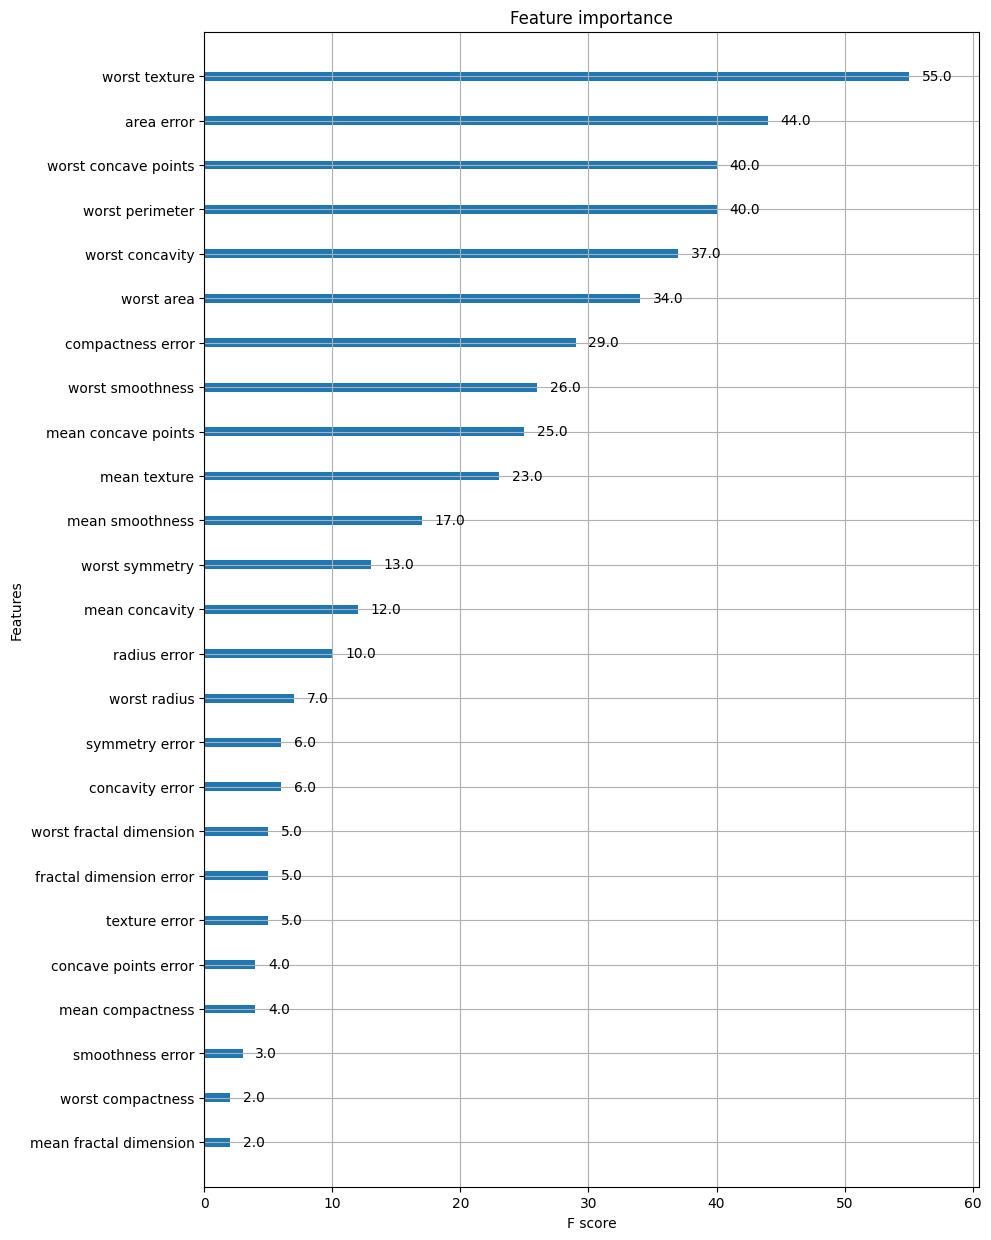

In [29]:
plt.figure(figsize=(10,15))
# xgb.DMatrix에서 feature_names 설정 안 하면 이름이 안 나와서 알아보기 어려움
plot_importance(xgb_model, ax=plt.gca())
plt.grid(True)
plt.show()
plt.close()